# 빅데이터 분석 특강 (4주차) 3월 28일 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Special Topics in Big Data Analysis, TensorFlow, TensorFlow NumPy]

### import 

In [6]:
import tensorflow as tf
import numpy as np

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import tensorflow.experimental.numpy as tnp 

In [9]:
tnp.experimental_enable_numpy_behavior()

### 미분 

#### tf.GradientTape() 사용방법

`-` 예제9: 카페예제로 돌아오자. 

In [81]:
x=tf.constant([20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4]) # 기온 

In [82]:
tf.random.set_seed(43052)
epsilon=tf.random.normal([10])
y=10.2 + 2.2*x + epsilon

In [83]:
y

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([55.418365, 58.194283, 61.230827, 62.312557, 63.107002, 63.69569 ,
       67.247055, 71.4365  , 73.1013  , 77.84988 ], dtype=float32)>

loss 정의하고 싶다. 

In [84]:
beta0 = tf.Variable(9.0)
beta1 = tf.Variable(2.0)

In [85]:
with tf.GradientTape(persistent=True) as tape:
    loss = sum( (y - beta0 -  beta0 * x)**2 )

In [86]:
tape.gradient(loss,beta0), tape.gradient(loss,beta1)

(<tf.Tensor: shape=(), dtype=float32, numpy=88965.67>, None)

`-` 예제10: 카페예제의 매트릭스 버전 

$\star$ 시험에 나와요 🍟

---

내 version...

In [ ]:
X=tf.transpose(tf.concat([[[1.0]*10],[x]],0))

In [12]:
tf.random.set_seed(43052)
epsilon=tf.reshape(tf.random.normal([10]),(10,-1))

In [13]:
Y=10.2 + 2.2*X + epsilon

In [14]:
with tf.GradientTape(persistent=True) as tape:
    loss = sum( (Y - beta0 -  beta0 * X)**2 )

In [15]:
tape.gradient(loss,beta0), tape.gradient(loss,beta1)

(<tf.Tensor: shape=(), dtype=float32, numpy=89184.18>, None)

---

교수님 version..

In [87]:
X = tnp.array([1]*10 + [20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4]).reshape(2,10).T

In [88]:
beta = tnp.array([9.0,2.0]).reshape(2,1)

In [89]:
tf.random.set_seed(43052)
epsilon=tf.random.normal([10])

In [90]:
beta_true = tnp.array([10.2,2.2]).reshape(2,1)
Y = X @ beta_true + epsilon.reshape(10,-1)

In [91]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta) # constant 일때 관찰되지 않으니 이 코드 꼭 써주기
    yhat = X @ beta
    loss = (y-yhat).T @ (y-yhat)

In [92]:
tape.gradient(loss,beta)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[ -12678.6920166 ],
       [-281954.48733521]])>

`-` 예제11: 위의 예제에서 이론적인 $\boldsymbol{\beta}$의 최적값을 찾아보고 (즉 $\boldsymbol{\hat\beta}$을 찾고) 그 지점에서 loss의 미분값(=접선의 기울기)를 구하라. 결과가 $\bf{0}$인지 확인하라. (단 ${\bf 0}$은 길이가 2이고 각 원소가 0인 벡터)

$\star$ 시험에 나와요 🍟

$\hat{\bf{B}} = (\bf{X}^\top \bf{X})^{-1}\bf{X}^\top \bf{y}$

---

내 answer

In [34]:
beta_hat= tf.linalg.inv(X.T @ X) @X.T @ y

In [37]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta_hat)
    yhat = X @ beta_hat
    loss = (y-yhat).T @ (y-yhat)

In [38]:
tape.gradient(loss,beta_hat)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-4.68958206e-12, -1.17672846e-10])>

이변량..loss를 미분해서 도함수를 구하고 베타를 대입..

---

In [93]:
-2*X.T @ y + 2*X.T@X@beta  # 확인 필요

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[  -126.78692017, -31901.63963623],
       [ 28566.01307983,  -3208.83963623]])>

$\hat{\bf{B}} = (\bf{X}^\top \bf{X})^{-1}\bf{X}^\top \bf{y}$

In [94]:
beta_optimal = tf.linalg.inv(X.T @ X) @ X.T @ y # 이보다 loss를 작게 만드는 beta는 없다.

In [95]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta_optimal)
    yhat = X @ beta_optimal
    loss = (y-yhat).T @ (y-yhat)

In [96]:
tape.gradient(loss,beta_optimal)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-4.68958206e-12, -1.17672846e-10])>

true값보다 optimal값이 더 최적...더 낫다

`-` beta_true에서 기울기를 계산해보자

In [97]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta_true)
    yhat = X @ beta_true
    loss = (y-yhat).T @ (y-yhat)

In [98]:
tape.gradient(loss,beta_true)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[ -274.6920166],
       [31783.5126648]])>

`-` 샘플사이즈가 커진다면 `tape.gradient(loss,beta_true)` 값과 `tape.gradient(loss,beta_optimal)` 값이 비슷해진다.

`-` $\therefore$ tape.gradient(loss,beta_true) $\approx$ tape.gradient(loss,beta_optimal) 과 같은 말

y를 최소화하는 x를 구해라 $\approx$ loss를 최소화하는  beta를 구해라

## 경사하강법 

In [57]:
import tensorflow as tf
import numpy as np 
import tensorflow.experimental.numpy as tnp 
import matplotlib.pyplot as plt

In [58]:
tnp.experimental_enable_numpy_behavior()

### 최적화문제 

`-` $loss=(\frac{1}{2}\beta-1)^2$를 최소하는 $\beta$를 컴퓨터를 활용하여 구하는 문제를 생각해보자.
- 답은 $\beta = 2$ 임을 알고 있다.

- beta를 수없이 만들어내서 계산을 해보자

### 방법1: grid search

#### 알고리즘 

(1) beta = [-10.00,-9.99,...,10.00] 와 같은 리스트를 만든다.

(2) (1)의 리스트의 각 원소에 해당하는 loss를 구한다.

(3) (2)에서 구한 loss를 제일 작게 만드는 beta를 찾는다.

#### 구현코드 

In [62]:
beta = tnp.linspace(-10,10,100)
loss = (beta*0.5 - 1)**2 # beta에 해당하는 loss값들

In [63]:
#collapse_output
loss

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([3.60000000e+01, 3.47980818e+01, 3.36165697e+01, 3.24554637e+01,
       3.13147638e+01, 3.01944700e+01, 2.90945822e+01, 2.80151005e+01,
       2.69560249e+01, 2.59173554e+01, 2.48990919e+01, 2.39012346e+01,
       2.29237833e+01, 2.19667381e+01, 2.10300990e+01, 2.01138659e+01,
       1.92180390e+01, 1.83426181e+01, 1.74876033e+01, 1.66529946e+01,
       1.58387920e+01, 1.50449954e+01, 1.42716049e+01, 1.35186205e+01,
       1.27860422e+01, 1.20738700e+01, 1.13821039e+01, 1.07107438e+01,
       1.00597898e+01, 9.42924191e+00, 8.81910009e+00, 8.22936435e+00,
       7.66003469e+00, 7.11111111e+00, 6.58259361e+00, 6.07448220e+00,
       5.58677686e+00, 5.11947760e+00, 4.67258443e+00, 4.24609734e+00,
       3.84001632e+00, 3.45434139e+00, 3.08907254e+00, 2.74420977e+00,
       2.41975309e+00, 2.11570248e+00, 1.83205795e+00, 1.56881951e+00,
       1.32598714e+00, 1.10356086e+00, 9.01540659e-01, 7.19926538e-01,
       5.58718498e-01, 4.1791

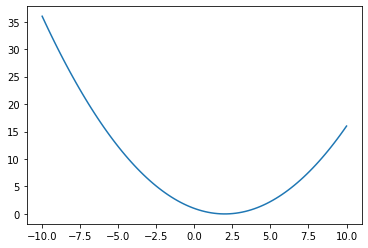

In [65]:
plt.plot(beta,loss)

`-` tnp.argmin

---

In [66]:
tnp.argmin([1,2,-3,3,4])

<tf.Tensor: shape=(), dtype=int64, numpy=2>

작은 값 리턴해주는 argmin

---

In [67]:
tnp.argmin(loss)

<tf.Tensor: shape=(), dtype=int64, numpy=59>

In [70]:
(beta[59]/2-1)**2

<tf.Tensor: shape=(), dtype=float64, numpy=0.0016324864809713507>

우리는 최적값이 2라는 것을 알고 있지, 잘 구했네~

In [71]:
(beta[60]/2-1)**2

<tf.Tensor: shape=(), dtype=float64, numpy=0.0036730945821854847>

뭐가 좋은지 어떻게 알아?
- 계산해보면 되지~ 59번째가 loss값더 작잖아

`-` 풀이 

`-` 최소지점 주변값과 비교 

#### 그리드서치의 문제점 

`-` 비판1: [-10,10]이외에 해가 존재하면? 
- 이 예제의 경우는 운좋게 [-10,10]에서 해가 존재했음
- 하지만 임의의 고정된 $x,y$에 대하여 $loss(\beta)=(x\beta-y)^2$ 의 형태의 해가 항상 [-10,10]에서 존재한다는 보장은 없음
- 해결책: 더 넓게 많은 범위를 탐색하자? (완전한 해결은 하지 못해..)(-100 ~ 100으로 범위 잡던가~)

`-` 비판2: 효율적이지 않음
- 알고리즘을 요약하면 결국 -10부터 10까지 작은 간격으로 조금씩 이동하며 loss를 조사하는 것이 grid search의 아이디어 
- $\to$ 생각해보니까 $\beta=2$인 순간 $loss=(\frac{1}{2}\beta-1)^2=0$이 되어서 이것보다 작은 최소값은 존재하지 않는다(제곱은 항상 양수이어야 하므로)
- $\to$ 따라서 $\beta=2$ 이후로는 탐색할 필요가 없다 

### 방법2: gradient descent

#### 알고리즘!

(1) 임의의 초기값(beta = -5로)을 선정하고 loss를 계산한다. 
 - $\beta=-5 \to loss(-5)=(-5/2-1)^2=12.25$

In [72]:
(-5/2-1)**2

12.25

(2) 임의의 초기값(beta = -5)에서 좌우로 약간씩 이동해보고 loss를 계산한다.(beta = -5 주변에서 조금씩 움직여보면서 계산해보자)
 - 왼쪽으로 이동: $\beta=-5.01,\quad loss(5.01)= 12.29$
 - 오른쪽으로 이동: $\beta=-4.99, \quad loss(-4.99)= 12.22$ 
 
 


- 즉 미분...

In [75]:
(-5.01/2-1)**2 

12.285025

In [73]:
(-4.99/2-1)**2

12.215025

-4.99가 최적값이다!( 말 바꾸기)

조금씩 움직이면서 말 계속 바꿔...

(3) (2)의 결과를 보고 어느쪽으로 이동하는것이 유리한지 따져보고 `유리한 방향으로` 이동한다. 
 - $\beta=-4.99$ 로 이동 


(4) (2)-(3) 의 과정을 반복한다. **왼쪽/오른쪽 모두 가봐도 유리한 지점이 없다면(이득이 없다면) 알고리즘을 멈춘다.**

알고리즘 분석

`-`(2)-(3)의 과정은 beta=-5에서 미분계수를 구하고 미분계수가 양수이면 왼쪽으로 움직이고, 미분계수가 음수이면 오른쪽으로 움직인다고 해석 가능. 아래 그림을 보면 더 잘 이해가 된다.

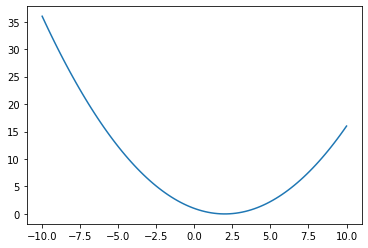

In [76]:
plt.plot(beta,loss)

#### 잠깐 알고리즘 감상 

`-` 정지조건?

`-` [-10,10] 이외에 해가 존재? 

`-` $\beta=2$를 찾았다면? 

`-` 알고리즘해석 
- (2)의 과정: 
- (3)의 과정: 

> Note: 이처럼 손실함수의 기울기(=경사)를 계산하여 점차적으로 가중치를 업데이트 하는 방식을 경사하강법이라고 부른다. 

#### 왼쪽/오른쪽중에 어디로 갈지 어떻게 판단하는 과정을 수식화?

`-` 아래와 같이 해석 가능
- 오른쪽으로 0.01 간다 = beta_old에 0.01을 더함. (if, 미분계수가 음수이면)
- 왼쪽으로 0.01 간다 = beta_old에 0.01을 뺌. (if, 미분계수가 양수이면)

`-` 그렇다면

$\beta_{new} = \begin{cases} \beta_{old} + 0.01, & loss'(\beta_{old}) <0 \\ \beta_{old} - 0.01,& loss'(\beta_{old}) \end{cases}$

`-` 미분계수가 + - ? 

`-` 수식화 

#### hoxy, 알고리즘을 좀 개선할수 있을까?

`-` 왜 0.01씩? 항상 0.01 씩 움직여야 할까

`-` 아이디어

보폭을 조정해보자, 최적값에 가까우면 보폭을 작게

`-` $\beta=-10$ 일 경우의 접선의 기울기? $\beta=-4$ 일때 접선의 기울기?

- $\beta = 10$ $\rightarrow$ 기울기는 -6

In [79]:
(-10/2-1)

-6.0

- $\beta = 4$ $\rightarrow$ 기울기는 -3

In [80]:
(-4/2-1)

-3.0

`-` 실제로 6,3씩 이동할 수는 없으니 적당한 $\alpha$를 잡아서 곱한만큼 이동하자

`-` 수식화 

- $\beta_{new} = \beta_{old} - \alpha loss' (\beta_{old})$
- $\beta_{new} = \beta_{old} - \alpha \big[ \frac{\partial}{\partial \alpha}loss(\beta) \big]_{\beta = \beta_{old}}$

$$\beta_{next} \leftarrow \beta_{old} -\alpha \left[\frac{\partial}{\partial \beta} loss(\beta)\right]_{\beta=\beta_{old}}$$

- 아까 수식이랑 좀 다르다?
- $\alpha$의 조건 
- $\alpha$의 의미 
- $\beta=-10$ 에서 $0.01$만큼 움직이기 위한 $\alpha$의 설정 

#### 구현코드 